In [ ]:
# pip install transformers

In [ ]:
import pandas as pd
import numpy as np
import torch
import re
from transformers import AutoTokenizer
from transformers import BertTokenizer

In [ ]:
# setting up GPU
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [ ]:
# reading the dataset
df = pd.read_csv('/content/drive/MyDrive/cov-tweets.csv', encoding='cp1252')

In [ ]:
df['label'] = df['label'].replace([1],0)
df['label'] = df['label'].replace([2],1)
df['label'] = df['label'].replace([3],2)

In [ ]:
sentences = df.tweet_text
label = df.label

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(sentences, label, test_size = 0.1)

In [ ]:
del sentences
del label

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)

In [ ]:
x_train = list(x_train)
y_train = list(y_train)

x_test = list(x_test)
y_test = list(y_test)

In [ ]:
for i in range(len(x_train)):
    x_train[i] = x_train[i][:-25]

In [ ]:
print('Original sentence :', x_train[2])
print('Tokenized :', tokenizer.tokenize(x_train[2]))
print('Tokens with ID:', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(x_train[2])))

Original sentence : Pro Tip: If you cry a little when you get your covid vaccine they’ll give you a sticker and a sucker for being such a “big girl” #COVID
Tokenized : ['pro', 'tip', ':', 'if', 'you', 'cry', 'a', 'little', 'when', 'you', 'get', 'your', 'co', '##vid', 'vaccine', 'they', '’', 'll', 'give', 'you', 'a', 'stick', '##er', 'and', 'a', 'sucker', 'for', 'being', 'such', 'a', '“', 'big', 'girl', '”', '#', 'co', '##vid']
Tokens with ID: [4013, 5955, 1024, 2065, 2017, 5390, 1037, 2210, 2043, 2017, 2131, 2115, 2522, 17258, 17404, 2027, 1521, 2222, 2507, 2017, 1037, 6293, 2121, 1998, 1037, 26476, 2005, 2108, 2107, 1037, 1523, 2502, 2611, 1524, 1001, 2522, 17258]


In [ ]:
max_len = 0
for sentence in x_train:
    input_ids = tokenizer.encode(sentence, add_special_tokens=True)
    max_len = max(max_len, len(input_ids))
print('Max sentence length: ', max_len)

Max sentence length:  337


In [ ]:
input_ids = []
attention_mask = []
for sentence in x_train:
    encoded_dict = tokenizer.encode_plus(
        sentence,
        add_special_tokens = True,
        max_length = 300,
        truncation = True,
        padding = 'max_length',
        return_attention_mask = True,
        return_tensors = 'pt'
    )
    input_ids.append(encoded_dict['input_ids'])
    attention_mask.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_mask, dim=0)
label = torch.tensor(y_train)

In [ ]:
from torch.utils.data import TensorDataset, random_split
dataset = TensorDataset(input_ids, attention_masks, label)
train_size = int(0.9*len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size, val_size])

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
batch_size = 32
train_dataloader = DataLoader(train_data,
                              sampler = RandomSampler(train_data),
                              batch_size = batch_size)

val_dataloader = DataLoader(val_data,
                             sampler = SequentialSampler(val_data),
                            batch_size = batch_size)

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = 3,
    output_attentions = False,
    output_hidden_states = False
)
model.cuda();

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
from transformers import get_linear_schedule_with_warmup
epochs = 4
total_steps = len(train_dataloader)*epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [ ]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import random
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

In [ ]:
training_stats = []
start_time = time.time()

for epoch_i in range(epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0_epoch = time.time()
    total_train_loss = 0

    model.train()
    for step, batch in enumerate(train_dataloader):
        if step%40 == 0 and not step == 0:
            print(f'Batch {step} of {len(train_dataloader)} -- Elapsed {time.time() - t0_epoch}')
        batch_input_ids = batch[0].to(device)
        batch_attention_mask = batch[1].to(device)
        batch_labels = batch[2].to(device)
        model.zero_grad()
        opt = model(batch_input_ids,
                             token_type_ids = None,
                             attention_mask = batch_attention_mask,
                             labels = batch_labels)
        loss, logits = opt.loss, opt.logits
        total_train_loss = total_train_loss + loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    avg_train_loss = total_train_loss / len(train_dataloader)
    epoch_train_time = time.time() - t0_epoch

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(epoch_train_time))

    print("")
    print("Running Validation...")

    t0_val = time.time()
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    try:
        for batch in val_dataloader:
            batch_input_ids = batch[0].to(device)
            batch_attention_mask = batch[1].to(device)
            batch_labels = batch[2].to(device)
        
            with torch.no_grad():
                eval_op = model(batch_input_ids,
                                token_type_ids = None,
                                attention_mask = batch_attention_mask,
                                labels = batch_labels)
                (loss, logits) = eval_op.loss, eval_op.logits
                total_eval_loss = total_eval_loss + loss
                logits = logits.detach().cpu().numpy()
                label_ids = batch_labels.to('cpu').numpy()
                total_eval_accuracy = total_eval_accuracy + flat_accuracy(logits,
                                                                        label_ids)
        avg_val_loss = total_eval_loss / len(val_dataloader)
        avg_val_accuracy = total_eval_accuracy / len(val_dataloader)
        validation_time = time.time() - t0_val

        print("  Validation Loss: {0:.2f}".format(avg_val_loss))
        print("  Validation took: {:}".format(validation_time))
    

        training_stats.append(
            {'epoch': epoch_i,
            'Training_loss': avg_train_loss,
            'Val Loss': avg_val_loss,
            'Val Acc': avg_val_accuracy,
            'Training_Time': epoch_train_time,
            'Val Time': validation_time
            }
        )
    except IndexError:
        pass

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
Batch 40 of 152 -- Elapsed 62.53574299812317
Batch 80 of 152 -- Elapsed 124.70173072814941
Batch 120 of 152 -- Elapsed 187.33908700942993

  Average training loss: 0.72
  Training epcoh took: 237.16557550430298

Running Validation...
  Validation Loss: 0.59
  Validation took: 10.028271675109863

======== Epoch 2 / 4 ========
Training...
Batch 40 of 152 -- Elapsed 62.44572615623474
Batch 80 of 152 -- Elapsed 124.84776711463928
Batch 120 of 152 -- Elapsed 187.34436511993408

  Average training loss: 0.53
  Training epcoh took: 237.123859167099

Running Validation...
  Validation Loss: 0.54
  Validation took: 9.997282266616821

======== Epoch 3 / 4 ========
Training...
Batch 40 of 152 -- Elapsed 62.48208498954773
Batch 80 of 152 -- Elapsed 125.01762819290161
Batch 120 of 152 -- Elapsed 187.52911520004272

  Average training loss: 0.40
  Training epcoh took: 237.31674718856812

Running Validation...
  Validation Loss: 0.57
  Validation took: 9.987

In [ ]:
training_metrics = pd.DataFrame(training_stats)
training_metrics['Training_loss'] = [float(x) for x in training_metrics['Training_loss']]
training_metrics['Val Loss'] = [float(x) for x in training_metrics['Val Loss']]
training_metrics.head()

,epoch,Training_loss,Val Loss,Val Acc,Training_Time,Val Time
0,0,0.720453,0.588562,0.742384,237.165576,10.028272
1,1,0.526114,0.539500,0.769958,237.123859,9.997282
2,2,0.401832,0.569485,0.771534,237.316747,9.987187
3,3,0.323315,0.554209,0.793592,237.033535,10.012484


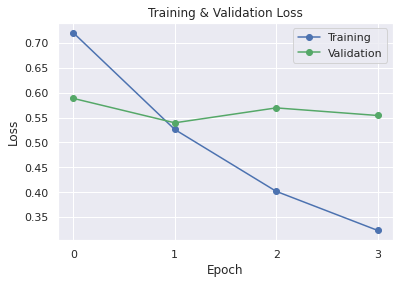

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
plt.plot(training_metrics['Training_loss'], 'b-o', label="Training")
plt.plot(training_metrics['Val Loss'], 'g-o', label="Validation")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([0, 1, 2, 3])
plt.show();

In [ ]:
input_ids_test = []
attention_mask_test = []
for sentence in x_test:
    encoded_dict = tokenizer.encode_plus(
        sentence,
        add_special_tokens = True,
        max_length = 64,
        truncation = True,
        padding = 'max_length',
        return_attention_mask = True,
        return_tensors = 'pt'
    )
    input_ids_test.append(encoded_dict['input_ids'])
    attention_mask_test.append(encoded_dict['attention_mask'])

input_ids_test = torch.cat(input_ids_test, dim=0)
attention_masks_test = torch.cat(attention_mask_test, dim=0)
label_test = torch.tensor(y_test)

batch_size = 32
prediction_dataset = TensorDataset(input_ids_test, attention_masks_test, label_test)
prediction_dataloader = DataLoader(prediction_dataset,
                             sampler = SequentialSampler(val_data),
                            batch_size = batch_size)

In [ ]:
model.eval()
predictions = []
true_labels = []
for batch in prediction_dataloader:
    b_input_ids = batch[0].to(device)
    b_attention_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    with torch.no_grad():
        outputs = model(b_input_ids, 
                        token_type_ids = None,
                        attention_mask = b_attention_mask)
    logits = outputs.logits
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    predictions.append(logits)
    true_labels.append(label_ids)

print('..DONE')

..DONE


In [ ]:
yhat = []
for pred in predictions:
    pred_i = np.argmax(pred, axis=1).flatten()
    yhat.append(pred_i)

In [ ]:
true_labels_ = []
for t in true_labels:
    true_labels_.append(t.flatten())

In [ ]:
from sklearn.metrics import accuracy_score
for (true, infer) in zip(true_labels_, yhat):
    print(accuracy_score(true, infer))

0.78125
0.6875
0.875
0.6875
0.78125
0.78125
0.65625
0.84375
0.71875
0.65625
0.78125
0.71875
0.75
0.71875
0.84375
0.75
0.7857142857142857
